In [1]:
%pip install --upgrade pip
%pip install numpy networkx scipy joblib
import Sequencer

     ---------------------------------------- 2.1/2.1 MB 13.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.3
    Uninstalling pip-22.0.3:
      Successfully uninstalled pip-22.0.3
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Note: you may need to restart the kernel to use updated packages.


# Import libraries

In [3]:
%pip install --upgrade pip
%pip install numpy networkx scipy joblib matplotlib pandas astropy requests json

# imports
%matplotlib inline


import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import curve_fit
from astropy.io import fits
from astropy.table import Table
from astropy.table import QTable
from astropy import units as u
from astropy.wcs import WCS
from astropy.visualization import quantity_support
from matplotlib.colors import LogNorm
import glob
import requests
import matplotlib as mpl
import matplotlib.cm as cm
import requests

import json


Note: you may need to restart the kernel to use updated packages.
  Using cached matplotlib-3.5.1-cp310-cp310-win_amd64.whl (7.2 MB)
  Using cached pandas-1.4.1-cp310-cp310-win_amd64.whl (10.6 MB)
  Using cached astropy-5.0.2-cp310-cp310-win_amd64.whl (6.4 MB)
  Using cached requests-2.27.1-py2.py3-none-any.whl (63 kB)
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json


ModuleNotFoundError: No module named 'matplotlib'

In [3]:
path_fits = 'dataset/fits/'
path_json = 'dataset/fits.json'

PATH_FILE = "PATH_FILE"
SPEC = "SPEC"
PLATE = "PLATE"
REDSHIFT = "REDSHIFT"

fits_json_object = json.load(open(path_json))
len(fits_json_object)

1937

In [4]:
spectra_list = []
wavelength_list = []
flux_raw_list = []
lamb_list = []
lambd_list = []
flux_bin_list = []
spectrax_list = []
#test_list = []

for f in fits_json_object:
    if float(f[REDSHIFT]) < 0.3:
        #opens fits file
        h = fits.open(f[PATH_FILE])
        data = h[1].data
        h1 = h[1].header
        name = (h.filename())[-25:-5]
        if name == 'spec-2013-53818-0635.fits':
            continue
        if name == 'spec-0958-52410-0606.fits':
            continue
        # Redshift value for AGN processed
        z = f[REDSHIFT]

        # flux and wavelenght from fits file
        lamb = 10**data['loglam']
        flux_raw = data['flux']
        w = WCS(h1, naxis=1, relax=False, fix=False)
        
        # rest-frame wavelength
        lambd = lamb/(1+z)
        
        #common wavelength grid from 4000˚ A to 7000
        lambda_bin=np.arange(3000)+4000
        
        #interpolate flux to common wavelengh 
        flux_bin = sp.interpolate.interp1d(lambd, flux_raw, kind='cubic')(lambda_bin)
        
        # logarithmic wavelength scale
        # TODO 

        lam = w.wcs_pix2world(np.arange(len(flux_bin)), 0)[0]
        log_lam_raw = np.log(lamb)
        
        # logarithmic rebinning
        log_lam = np.linspace(min(log_lam_raw), max(log_lam_raw), num=len(lam))

        # remove continuum of spectra
        def fit_polynom(log_lam, a0, a1, a2, a3, a4, a5):
            """fit func = 2 nd order polynom"""
            return a0+a1*log_lam+a2*(log_lam)**2+a3*(log_lam)**3+a4*(log_lam)**4+a5*(log_lam)**5
        
        # intitialize fit paramters
        init_fit_param = [0, 0, 0, 0 ,0, 0]
        
        # fit data using scipy.curve_fit()
        fit_params, fit_covariances = curve_fit(fit_polynom, log_lam, flux_bin, p0=init_fit_param, maxfev=5000)
        
        # remove continuum by dividing flux by fit polynomial
        flux = (flux_bin - (fit_polynom(log_lam, *fit_params))) -1
        fflux = flux / lambd.sum()

        lamb_list.append(lamb)
        flux_raw_list.append(flux_raw)
        spectrax_list.append(flux)
        spectra_list.append(fflux)
        lambd_list.append(lambd)
        flux_bin_list.append(flux_bin)
        wavelength_list.append(lambda_bin)
        #test_list.append({"filename":name, "flux":fflux})
        
        
print("number of stellar spectra: %s" % len(spectra_list))
print("length of each spectrum: %s" % len(spectra_list[0]))

number of stellar spectra: 1937
length of each spectrum: 3000


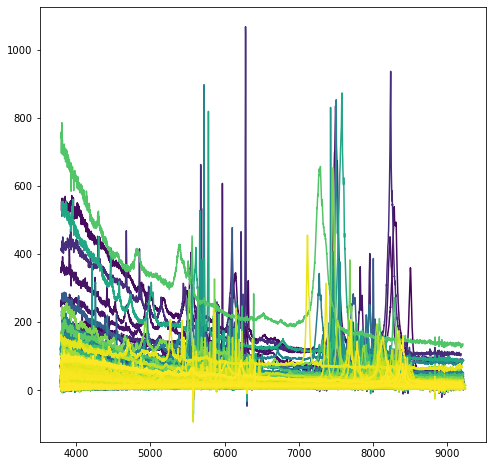

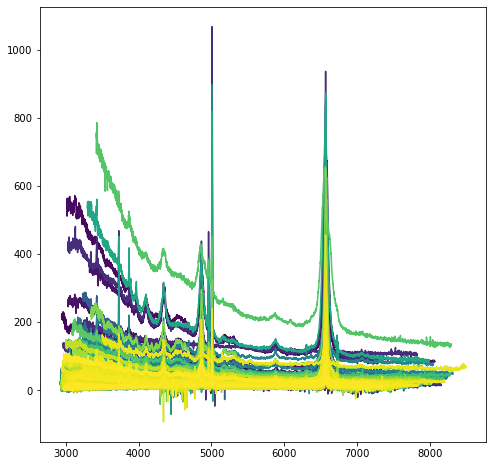

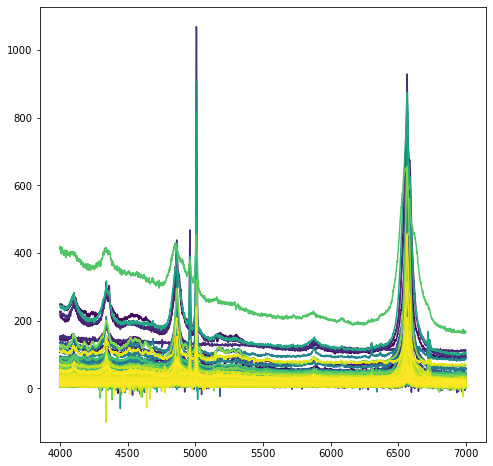

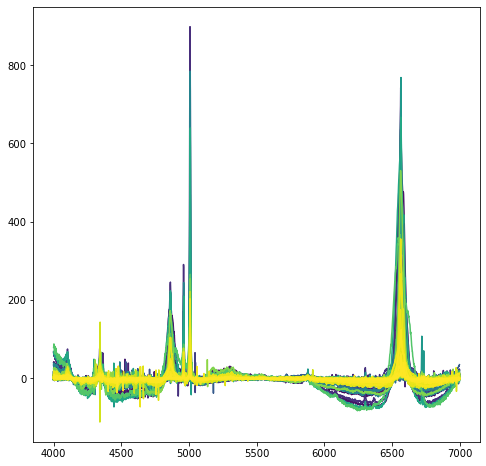

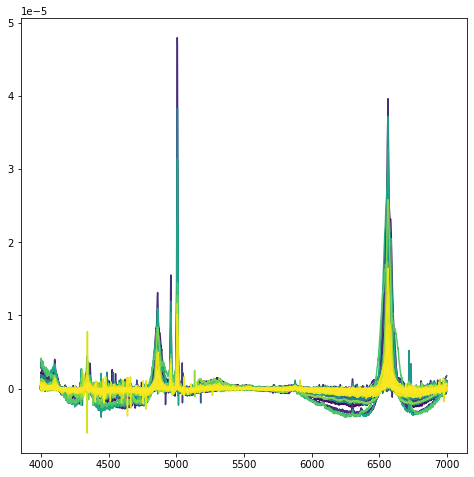

In [5]:
########################## ploting option ################################################
norm = mpl.colors.Normalize(vmin=0, vmax=len(spectra_list)-1)
cmap = cm.viridis
m = cm.ScalarMappable(norm=norm, cmap=cmap)

plt.figure(1, figsize=(8, 8))
for i in range(0, len(spectra_list), 5 ):
    plt.plot(lamb_list[i], flux_raw_list[i], color=m.to_rgba(i))

########################## ploting option ################################################
plt.figure(2, figsize=(8, 8))
for i in range(0, len(spectra_list), 5):
    plt.plot(lambd_list[i], flux_raw_list[i], color=m.to_rgba(i))

########################## ploting option ################################################
plt.figure(3, figsize=(8, 8))
for i in range(0, len(spectra_list), 5):
    plt.plot(wavelength_list[i], flux_bin_list[i], color=m.to_rgba(i)) #ok hasta aqui

########################## ploting option ################################################
plt.figure(4, figsize=(8, 8))
for i in range(0, len(spectra_list), 5):
    plt.plot(wavelength_list[i], spectrax_list[i], color=m.to_rgba(i))

########################## ploting option ################################################
plt.figure(5, figsize=(8, 8))
for i in range(0, len(spectra_list), 5):
    plt.plot(wavelength_list[i], spectra_list[i], color=m.to_rgba(i))

(3000,) (1937, 3000)


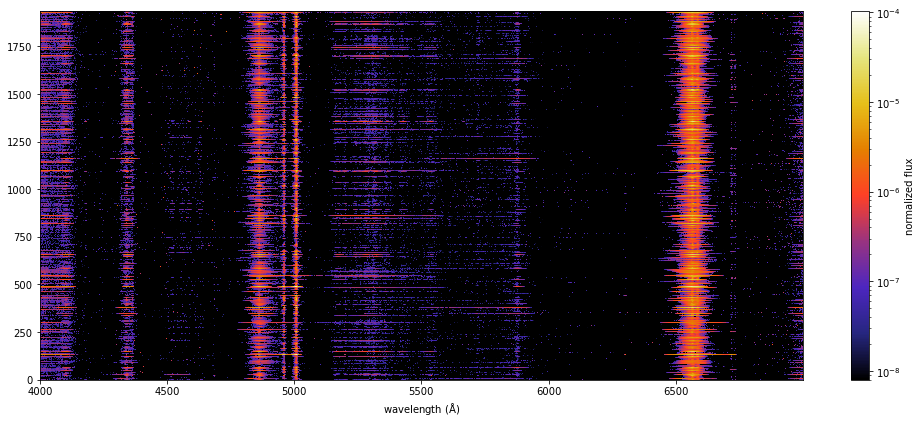

In [6]:
# load the spectra and construct the wavelength range 
wavelength = np.arange(4000, 7000, 1)
spectra_matrix = np.asarray(spectra_list)
print(wavelength.shape, spectra_matrix.shape)

indices_for_plot = np.arange(len(spectra_matrix))
X, Y = np.meshgrid(wavelength, indices_for_plot)

plt.figure(1, figsize=(14, 6))
plt.pcolormesh(X, Y, spectra_matrix.clip(0.000000008, 0.00018), cmap="CMRmap", norm=LogNorm(), shading='auto')
plt.xlabel("wavelength ($\\mathrm{\\AA}$)")
plt.colorbar(label="normalized flux")
plt.tight_layout()

In [7]:
## Normalizing dataset (Min-Max normalization)
spectrum = spectra_matrix.data
n1 = spectrum - np.min(spectrum)
n2 = np.max(spectrum) - np.min(spectrum)
norm_spectrum = n1/n2
#norm_spectrum = norm_spectrum + 1

In [9]:
print('avg', np.median(norm_spectrum))
print('max', np.max(norm_spectrum))
print('min', np.min(norm_spectrum))

avg 0.05440907465719898
max 1.0
min 0.0


In [13]:
#Parametros del secuenciador, tanto metricas como escalas
estimator_list = ['EMD','energy', 'L2']
scale_list = [[1,2,8], [1,2,8], [1,2,8]]

In [14]:
seq = Sequencer(wavelength, norm_spectrum, estimator_list, scale_list)
output_path = 'dataset/fits/'
final_elongation, final_sequence = seq.execute(output_path, to_average_N_best_estimators=True, 
                                              number_of_best_estimators=2,
                                              to_use_parallelization=True)
print("resulting elongation for the Sequencer: ", final_elongation)

# print the intermediate elongations for different metrics + scales
estimator_list, scale_list, elongation_list = seq.return_elongation_of_weighted_products_all_metrics_and_scales()

print("Intermediate elongations for the different metrics and scales:")
for i in range(len(estimator_list)):
    print("metric=%s, scale=%s, elongation: %s" % (estimator_list[i], 
                                                   scale_list[i], 
                                                   elongation_list[i]))

# order the input dataset according to the detected sequence
objects_list_ordered = spectra_matrix[final_sequence]

Parallelization is ON. Number of cores: 16
calculating the distance matrices for estimator: EMD, scale: 1
finished calculating this distance matrix list, it took: 79.73966431617737 seconds
calculating the distance matrices for estimator: EMD, scale: 2
finished calculating this distance matrix list, it took: 91.2102038860321 seconds
calculating the distance matrices for estimator: EMD, scale: 8
finished calculating this distance matrix list, it took: 182.95575094223022 seconds
calculating the distance matrices for estimator: energy, scale: 1
finished calculating this distance matrix list, it took: 79.53024482727051 seconds
calculating the distance matrices for estimator: energy, scale: 2
finished calculating this distance matrix list, it took: 90.37815523147583 seconds
calculating the distance matrices for estimator: energy, scale: 8
finished calculating this distance matrix list, it took: 173.82472610473633 seconds
calculating the distance matrices for estimator: L2, scale: 1
finished 

C:\Users\davos\AppData\Local\Temp/ipykernel_33876/533716621.py:893: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ordering_bfs = numpy.array(ordering_bfs).astype(numpy.int)


in estimator: EMD, scale: 2
in estimator: EMD, scale: 8
in estimator: energy, scale: 1
in estimator: energy, scale: 2
in estimator: energy, scale: 8
in estimator: L2, scale: 1
in estimator: L2, scale: 2
in estimator: L2, scale: 8
dumped the elongations to the file: dataset/fits//elongations.pkl
dumped the full weighted distance matrix to the file: dataset/fits//weighted_distance_matrix.pkl


C:\Users\davos\AppData\Local\Temp/ipykernel_33876/533716621.py:1021: RuntimeWarning: divide by zero encountered in true_divide
  distance_matrix = 1.0 / proximity_matrix_copy


dumped the sparse distance matrix to the file: <_io.BufferedWriter name='dataset/fits//sparse_distance_matrix.pkl'>
dumped the final sequences and elongation to the file: <_io.BufferedWriter name='dataset/fits//final_products.pkl'>
resulting elongation for the Sequencer:  21.569220587909975
Intermediate elongations for the different metrics and scales:
metric=EMD, scale=1, elongation: 20.97238836461602
metric=EMD, scale=2, elongation: 25.087964479450658
metric=EMD, scale=8, elongation: 21.048356476292845
metric=energy, scale=1, elongation: 15.052381562854064
metric=energy, scale=2, elongation: 21.569220587909975
metric=energy, scale=8, elongation: 17.66188340042255
metric=L2, scale=1, elongation: 4.561075264747657
metric=L2, scale=2, elongation: 5.668737934668437
metric=L2, scale=8, elongation: 5.187855496673881


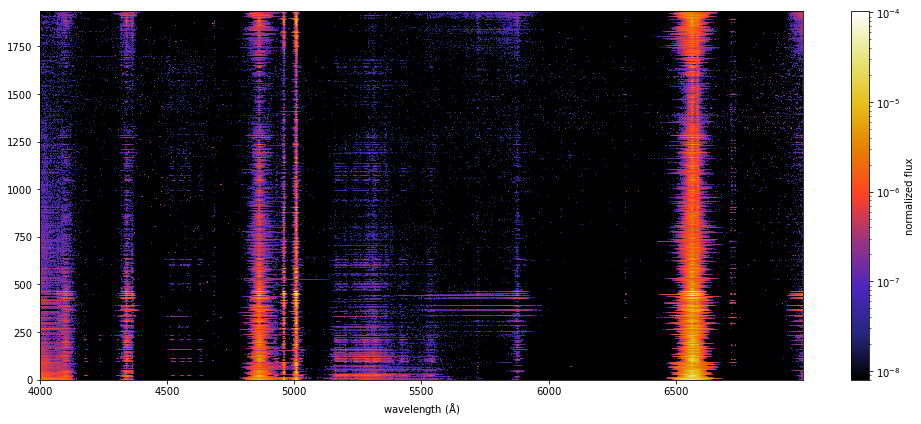

In [15]:
# plot the ordered dataset
plt.figure(1, figsize=(14, 6))
plt.pcolormesh(X, Y, objects_list_ordered.clip(0.000000008, 0.00018), cmap="CMRmap", norm=LogNorm(), shading='auto')
plt.xlabel("wavelength ($\\mathrm{\\AA}$)")
plt.colorbar(label="normalized flux")
plt.tight_layout()

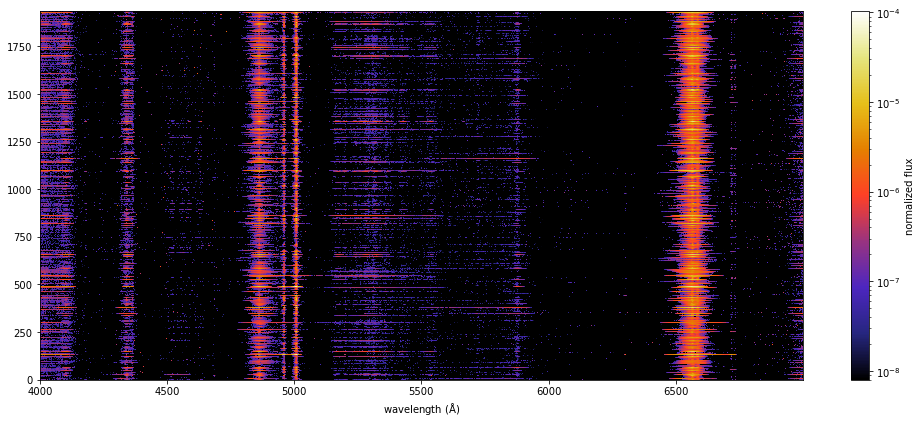

In [16]:
# comparison original
plt.figure(1, figsize=(14, 6))
plt.pcolormesh(X, Y, spectra_matrix.clip(0.000000008, 0.00018), cmap="CMRmap", norm=LogNorm(), shading='auto')
plt.xlabel("wavelength ($\\mathrm{\\AA}$)")
plt.colorbar(label="normalized flux")
plt.tight_layout()

The highest enlongation can be found in EMD at scale 2. We will execute the sequencer again with only this paremeters, utilizing the same distance metrix obtain in the prevoius step.

In [19]:
#Parametros del secuenciador, tanto metricas como escalas
estimator_list = ['EMD']
scale_list = [[2]]

In [20]:
seq = Sequencer(wavelength, norm_spectrum, estimator_list, scale_list)
output_path = 'dataset/fits/'
final_elongation, final_sequence = seq.execute(output_path, to_calculate_distance_matrices=False,
                                               to_save_distance_matrices=False,
                                               distance_matrices_inpath="dataset/fits/distance_matrices.pkl")
print("resulting elongation for the Sequencer: ", final_elongation)

# print the intermediate elongations for different metrics + scales
estimator_list, scale_list, elongation_list = seq.return_elongation_of_weighted_products_all_metrics_and_scales()

print("Intermediate elongations for the different metrics and scales:")
for i in range(len(estimator_list)):
    print("metric=%s, scale=%s, elongation: %s" % (estimator_list[i], 
                                                   scale_list[i], 
                                                   elongation_list[i]))

# order the input dataset according to the detected sequence
objects_list_ordered = spectra_matrix[final_sequence]

strating to sequence the different scales and estimators
in estimator: EMD, scale: 2


C:\Users\davos\AppData\Local\Temp/ipykernel_33876/533716621.py:893: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ordering_bfs = numpy.array(ordering_bfs).astype(numpy.int)


dumped the elongations to the file: dataset/fits//elongations.pkl
dumped the full weighted distance matrix to the file: dataset/fits//weighted_distance_matrix.pkl


C:\Users\davos\AppData\Local\Temp/ipykernel_33876/533716621.py:1021: RuntimeWarning: divide by zero encountered in true_divide
  distance_matrix = 1.0 / proximity_matrix_copy


dumped the sparse distance matrix to the file: <_io.BufferedWriter name='dataset/fits//sparse_distance_matrix.pkl'>
dumped the final sequences and elongation to the file: <_io.BufferedWriter name='dataset/fits//final_products.pkl'>
resulting elongation for the Sequencer:  25.087964479450658
Intermediate elongations for the different metrics and scales:
metric=EMD, scale=2, elongation: 25.087964479450658


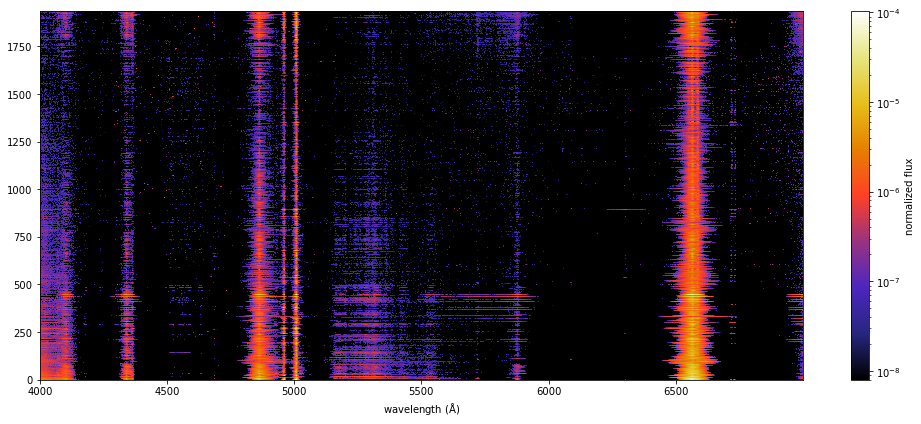

In [21]:
# plot the ordered dataset
plt.figure(1, figsize=(14, 6))
plt.pcolormesh(X, Y, objects_list_ordered.clip(0.000000008, 0.00018), cmap="CMRmap", norm=LogNorm(), shading='auto')
plt.xlabel("wavelength ($\\mathrm{\\AA}$)")
plt.colorbar(label="normalized flux")
plt.tight_layout()

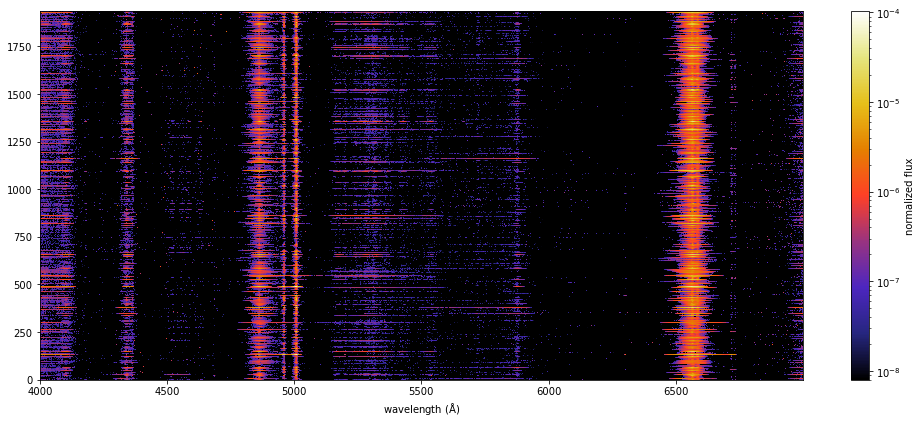

In [22]:
# comparison original
plt.figure(1, figsize=(14, 6))
plt.pcolormesh(X, Y, spectra_matrix.clip(0.000000008, 0.00018), cmap="CMRmap", norm=LogNorm(), shading='auto')
plt.xlabel("wavelength ($\\mathrm{\\AA}$)")
plt.colorbar(label="normalized flux")
plt.tight_layout()

In [23]:
final_mst = seq.return_final_MST()
type(final_mst)

networkx.classes.graph.Graph

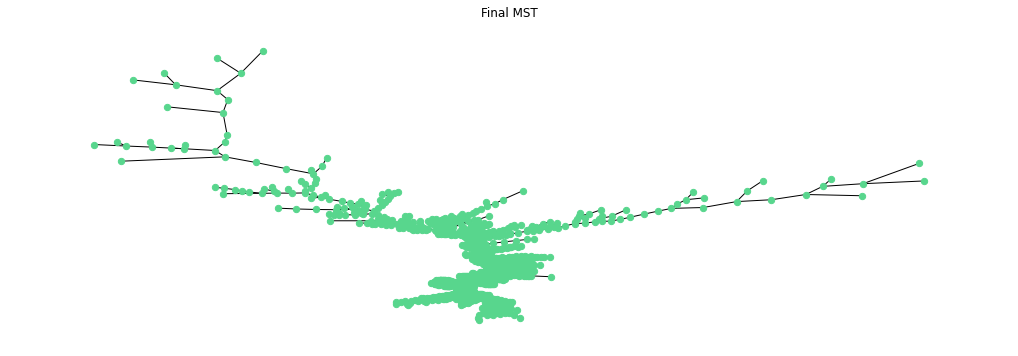

In [24]:
plt.figure(1, figsize=(18, 6))

plt.title("Final MST")
pos = nx.kamada_kawai_layout(final_mst)
nx.draw(final_mst, pos, node_color="#58D68D", node_size=40)